<h1><center>Análise de Crédito (Give me some credit!)</center></h1>

Neste exercício vamos construir um classificador para prever inadimplência de tomadores de empréstimo. O problema foi apresentado na plataforma Kaggle (https://www.kaggle.com/c/GiveMeSomeCredit), com o prêmio de 5000 USD para o ganhador. Os atributos disponíveis nos dados são descritos abaixo:

<img src="DescricaoAtributos.png">

Segundo as regras, a avaliação do modelo deve ser feita pela métrica AUC, sendo que melhor resultado obtido pelos participantes nos testes foi 0.8695:

<img src="Kaggle_Ranking.png">

Para facilitar, primeiro implementamos cada uma das etapas da Extração de Conhecimento em rotinas separadas, em seguida essas são chamadas abaixo no programa principal.

## 0. Importação de módulos

In [1]:
!pip install scikit-plot

In [20]:
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings('ignore')

## 1.1. Carga de dados

In [3]:
# Para este problema temos dois arquivos: treino e tete. O arquivo de teste, no entanto, não está rotulado, 
# logo trabalharemos apenas com os dados de treino
def carrega_treino():
    url = "https://raw.githubusercontent.com/brvnl/AplicacoesAprendizadoMaquina/main/cs-training.csv"
    df = pd.read_csv(url)
    df.drop(columns="Unnamed: 0", inplace=True)
    return df

## 1.2. Análise exploratória

In [4]:
# Para atributos numéricos discretos, esta função conta a quantidade de registros por valor,
# providenciando a distribuição para as duas classes.
def countplot_comparisson(df):
    int_attr = ["age", 
                "NumberOfDependents",
                "NumberOfOpenCreditLinesAndLoans", 
                "NumberRealEstateLoansOrLines", 
                "NumberOfTime30-59DaysPastDueNotWorse", 
                "NumberOfTime60-89DaysPastDueNotWorse",
                "NumberOfTimes90DaysLate"]
    
    for c in int_attr:
        fig2, ax2 = plt.subplots(figsize=(20,8))
        sns.countplot(x=c, hue="SeriousDlqin2yrs", data=df).set_title(c)
        
    return

# Para atributos numéricos contínuos esta função exibe a distribuição dos dados em formato 
# box-plot, um para cada classe.
def boxplot_comparisson(df):
    float_attr = ["MonthlyIncome", 
                  "RevolvingUtilizationOfUnsecuredLines", 
                  "DebtRatio"]
    
    for c in float_attr:
        fig3, ax3 = plt.subplots(figsize=(20,8))
        
        g = sns.boxplot(x="SeriousDlqin2yrs", hue="SeriousDlqin2yrs", y=c, data=df)
        g.set_title(c)
        g.set_yscale("log")
        
# Checa a correlação entre cada um dos atributos (são todos numéricos)
def check_correlation(df): 
    fig, ax = plt.subplots(figsize=(20,8))
    sns.heatmap(
        df.corr(), 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot = True
    ).set_title('Correlação')
    
    return 

# Exibe informações básicas sobre o dataset. Comente/ descomente as linhas 
# conforme quiser.
def analise_exploratoria(df):
    fig1, ax1 = plt.subplots(figsize=(20,8))
    sns.countplot(x="SeriousDlqin2yrs", data=df).set_title('Balanceamento de Classes')

    #countplot_comparisson(df)
    #boxplot_comparisson(df)
    check_correlation(df)
    
    return

## 1.3 Pré Processamento

In [5]:
# Ajusta a diferença de registros entre as classes
def reamostragem(X, Y):
    smt = SMOTETomek(sampling_strategy='all')
    X_smt, y_smt = smt.fit_resample(X, Y)

    previous_pos = len(Y[Y["SeriousDlqin2yrs"]==1])
    previous_neg = len(Y[Y["SeriousDlqin2yrs"]==0])
    current_pos = len(y_smt[y_smt==1])
    current_neg = len(y_smt[y_smt==0])
    
    print("INFO* Antes da reamostragem: Pos=%d/ Neg=%d; Após reamostragem: Pos=%d/ Neg=%d." %(previous_pos, previous_neg, current_pos, current_neg))
    
    return (X_smt, y_smt)

# Normaliza os valores numéricos pela média e desvio padrão.
def normalizacao_mean_std(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X


# Esta função deve realizar todas as etapas de pre-processamento antes de calibrar o modelo.
def preprocessamento(df):
    
    # Descar linhas NaN
    #df.dropna(axis=0, how="any", inplace=True)
    
    # Preenche NaNs com a média
    #for c in df.columns:
        #df[c].fillna((df[c].mean()), inplace=True)
        
    # Preenche NaNs com zero
    for c in df.columns:
        df[c].fillna(0, inplace=True)
    
    # Separando 
    Y = df["SeriousDlqin2yrs"].to_frame()
    X = df.drop(columns="SeriousDlqin2yrs")
    
    # Normalizar atributos independentes
    #X = normalizacao_mean_std(X)

    return (X, Y)

## 2. Amostragem e treino

## 2.1 - KNN com GridSearch - Com e Sem Reamostragem

In [6]:
# Esta função deve reunir todas as etapas para a obtenção do modelo, seja diretamente
# sobre os dados de treino (Hold Out) ou por otimização Validação Cruzada + Grid Search.
# Escolha o método de classificação de sua preferência.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import scipy.stats

def otimizacao_rs(X_train_rs, Y_train_rs):
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_rs, y_train_rs)

    scores = cross_val_score(knn, X, Y, cv=5) # 5 execuções diferentes com 20% dos dados para teste

    print('Acurácia - %.2f +- %.2f' % (scores.mean() * 100, scores.std() * 100))    

    grid_params = {
        'n_neighbors': [3, 5, 11, 20],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        #'algorithm': ['ball_tree', 'kd_tree']
        #'leaf_size' : [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    }


    gs = GridSearchCV(knn, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train_rs, y_train_rs)
    
    model = gs_results

    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)

    
    return model


def otimizacao(X_train, Y_train):


    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)

    scores = cross_val_score(knn, X, Y, cv=5) # 5 execuções diferentes com 20% dos dados para teste

    print('Acurácia - %.2f +- %.2f' % (scores.mean() * 100, scores.std() * 100))    

    grid_params = {
        'n_neighbors': [3, 5, 11, 20],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        #'algorithm': ['ball_tree', 'kd_tree']
        #'leaf_size' : [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    }

    gs = GridSearchCV(knn, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train, y_train)
    
    model = gs_results

    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    
    return model


## 2.2 - XGBoost com escalonamento e sem escalonamento de pesos

In [29]:
!pip install xgboost

In [36]:
import xgboost as xgb

def otimizacao_xgb(X_train, Y_train):

    model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    model.fit(X_train,y_train)
    
    print('Score:', model.score(X_test,y_test))
    
    return model

def otimizacao_xgb_w(X_train, Y_train):
    
    weight = int(y_train.count()/y_train.sum())

    model = xgb.XGBClassifier(objective="binary:logistic", random_state=42,scale_pos_weight = weight)    
    model.fit(X_train,y_train)
    
    print('Score:', model.score(X_test,y_test))
    
    return model


## 2.3 - Random Forest com GridSearch

In [54]:
from sklearn.ensemble import RandomForestClassifier

def otimizacao_rf(X_train, Y_train):


    grid_params = {
        'criterion': ['gini','entropy'],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3],
        'n_estimators': [50, 70, 100]
   }

    dtc = RandomForestClassifier()
    
    gs = GridSearchCV(dtc, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train, y_train)
    
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    
    return model

def otimizacao_rf_best(X_train, Y_train):


    grid_params = {
        'criterion': ['entropy'],
        'max_depth': [80],
        'max_features': [2],
        'n_estimators': [100]
   }

    dtc = RandomForestClassifier()
    
    gs = GridSearchCV(dtc, grid_params, cv=5, n_jobs=1)

    gs_results = gs.fit(X_train, y_train)
    
    print(gs_results.best_score_)
    #print(gs_results.best_estimator_)
    #print(gs_results.best_params_)
    
    return model


## 3. Resultados

In [21]:
# Essa função exibe os resultados da classificação pelo modelo gerado. Para tanto, a função
# espera receber um dicionário cuja primeira chave é a fase (Treino, Validação e Teste) e a 
# segunda os dados (actual, pred e pred_prob).
def resultados(res):

    # Medidas de acerto 
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        print(classification_report(res[phase]["actual"], res[phase]["pred"]))
    
    # Matriz de Confusão
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_confusion_matrix(res[phase]["actual"], res[phase]["pred"])
        plt.show()
    
    # Curva ROC-AUC
    for phase in res.keys():
        print("-------------------------------------------------------------")
        print("Evaluating %s" %(phase))
        skplt.metrics.plot_roc_curve(res[phase]["actual"], res[phase]["prob"])
        plt.show()
    
    prob_tst = model.predict_proba(X_test)
    prob_1 = prob_tst[:,1]
    
    prob_tr = model.predict_proba(X_train)
    prob_2 = prob_tr[:,1]
    
    print('AUC Score Train: ', (roc_auc_score(y_train,prob_2)))
    print('AUC Score Test: ', (roc_auc_score(y_test,prob_1)))


    return

# Programa Principal

Carregando os dados:

In [8]:
# Carrega os dados para um daframe
df_treino = carrega_treino()
print("INFO* Registros de treino orginais: %d; Colunas: %d." %(df_treino.shape))

INFO* Registros de treino orginais: 150000; Colunas: 11.


Análise exploratória (opcional):

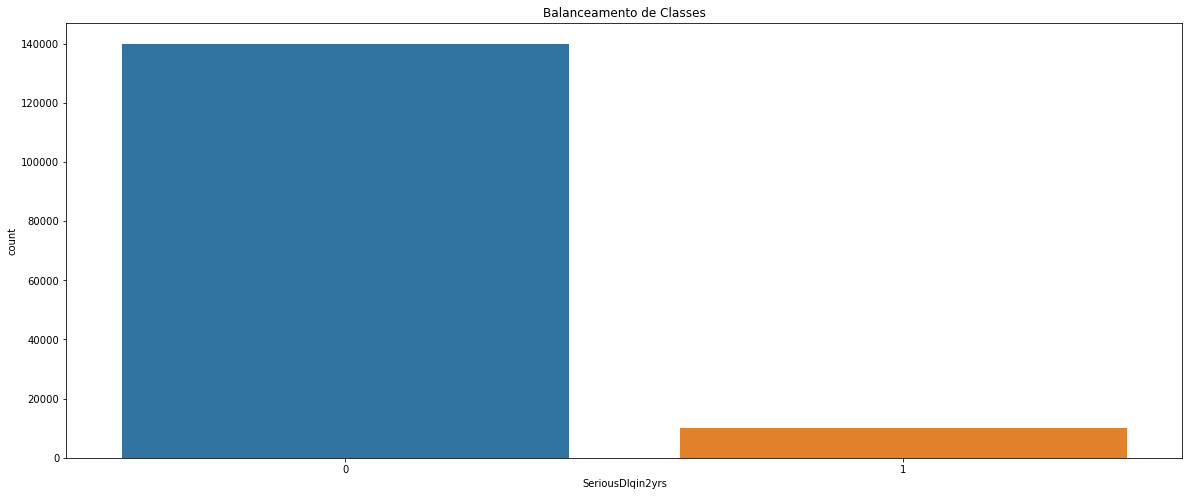

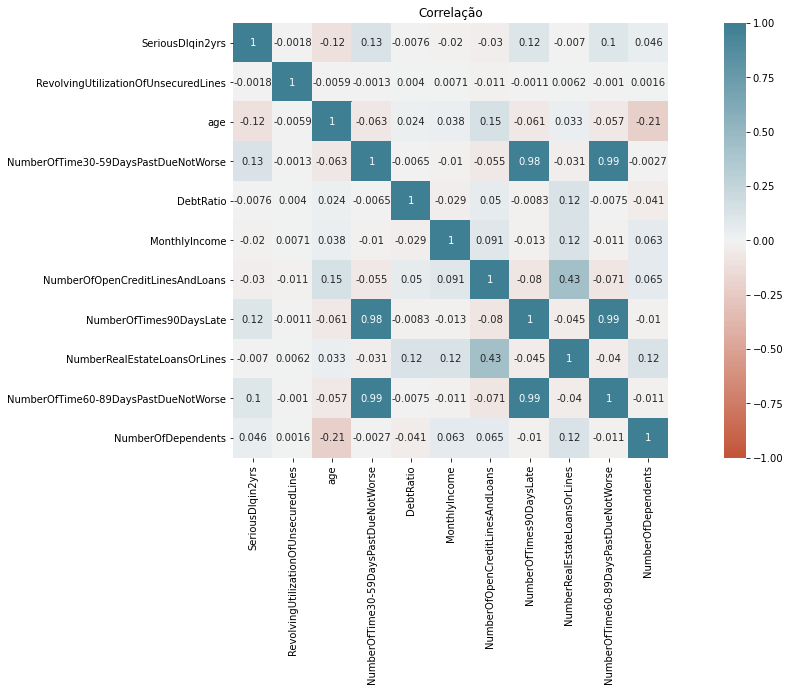

In [9]:
# Exibe características do atributo alvo, dos demais atributos e da relação entre eles.
analise_exploratoria(df_treino)

Pré-processamento e separação Treino/Teste:

In [10]:
# Executa todas as rotinas de preprocessamento e separa atributo alvo
X, Y = preprocessamento(df_treino)
print("INFO* Registros após preproc: %d; Colunas em X: %d; Colunas em Y: 1." %(X.shape))

# Separa 5% dos dados para teste (+- 5000 registros)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, stratify=Y, shuffle=True)
print("INFO* Registros separados para treino: %d; teste: %d." %(len(y_train), len(y_test)))

INFO* Registros após preproc: 150000; Colunas em X: 10; Colunas em Y: 1.
INFO* Registros separados para treino: 142500; teste: 7500.


Ajuste de balanceamento (opcional):

In [11]:
# Emprega tecnicas de reamostragem para tratar o desbalanceamento de classes
X_train_rs, y_train_rs = reamostragem(X_train, y_train)
print("INFO* Registros de treino após reamostragem: %d linhas, %d colunas." %(X_train_rs.shape))

INFO* Antes da reamostragem: Pos=9525/ Neg=132975; Após reamostragem: Pos=260624/ Neg=260624.
INFO* Registros de treino após reamostragem: 260624 linhas, 10 colunas.


Calibrando o modelo:

Analisando os resultados

# Resultado 2.1 - Sem Reamostragem

In [15]:
# Treinamento com dados sem reamostragem
model = otimizacao(X_train, y_train)

Acurácia - 92.76 +- 0.08
0.9334877192982456
KNeighborsClassifier(metric='manhattan', n_neighbors=20)
{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.93      1.00      0.97    132975
           1       0.77      0.01      0.02      9525

    accuracy                           0.93    142500
   macro avg       0.85      0.50      0.49    142500
weighted avg       0.92      0.93      0.90    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      6999
           1       0.67      0.01      0.02       501

    accuracy                           0.93      7500
   macro avg       0.80      0.50      0.49      7500
weighted avg       0.92      0.93      0.90      7500

-------------------------------------------------------------
Evaluating train


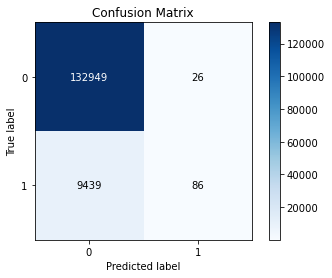

-------------------------------------------------------------
Evaluating test


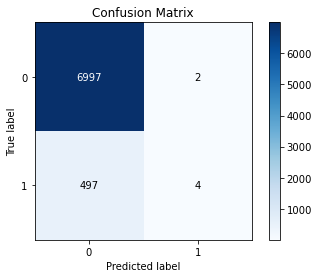

-------------------------------------------------------------
Evaluating train


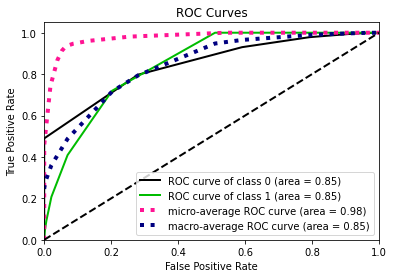

-------------------------------------------------------------
Evaluating test


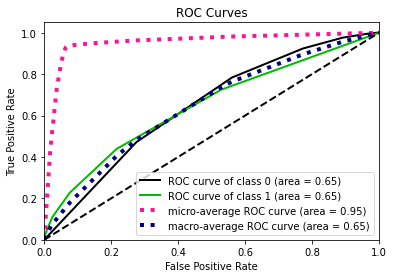

AUC Score Train:  0.8466652846059217
AUC Score Test:  0.6452006688152485


In [22]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.1 - Com Reamostragem

In [13]:
# Treinamento com dados com reamostragem
model = otimizacao_rs(X_train_rs, y_train_rs)

Acurácia - 92.76 +- 0.08
0.898558846079456
KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    132975
           1       0.87      1.00      0.93      9525

    accuracy                           0.99    142500
   macro avg       0.93      0.99      0.96    142500
weighted avg       0.99      0.99      0.99    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6999
           1       0.10      0.29      0.15       501

    accuracy                           0.79      7500
   macro avg       0.52      0.56      0.52      7500
weighted avg       0.89      0.79      0.83      7500

-------------------------------------------------------------
Evaluating train


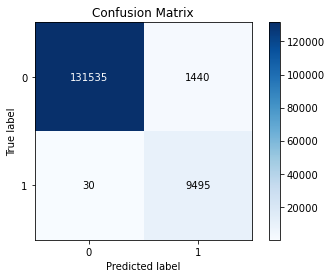

-------------------------------------------------------------
Evaluating test


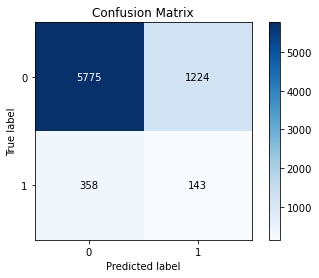

-------------------------------------------------------------
Evaluating train


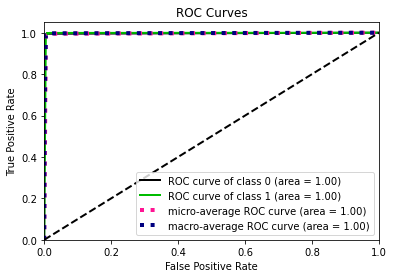

-------------------------------------------------------------
Evaluating test


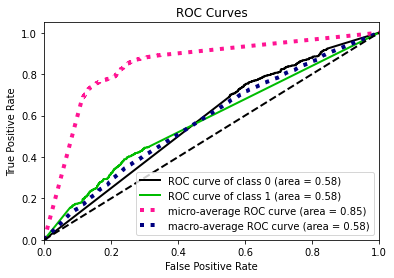

In [14]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.2 - XGBoost Sem Escalonamento

In [39]:
model = otimizacao_xgb(X_train, y_train)

[21:09:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 0.9366666666666666


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    132975
           1       0.78      0.29      0.42      9525

    accuracy                           0.95    142500
   macro avg       0.87      0.64      0.70    142500
weighted avg       0.94      0.95      0.94    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      6999
           1       0.58      0.19      0.28       501

    accuracy                           0.94      7500
   macro avg       0.76      0.59      0.63      7500
weighted avg       0.92      0.94      0.92      7500

-------------------------------------------------------------
Evaluating train


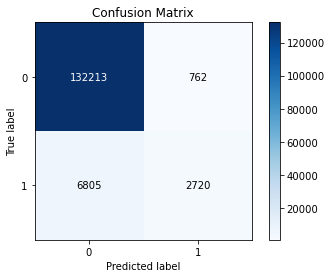

-------------------------------------------------------------
Evaluating test


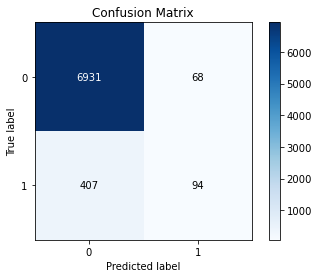

-------------------------------------------------------------
Evaluating train


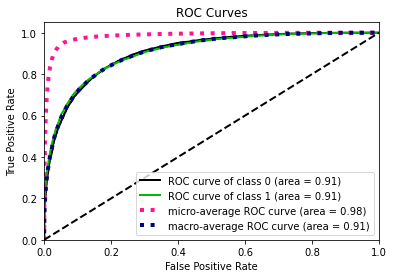

-------------------------------------------------------------
Evaluating test


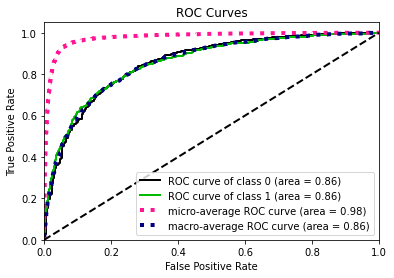

AUC Score Train:  0.9057658295251164
AUC Score Test:  0.855308385942788


In [34]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.2 - XGBoost Com Escalonamento

In [37]:
model = otimizacao_xgb_w(X_train, y_train)

[21:08:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score: 0.8156


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.99      0.84      0.90    132975
           1       0.27      0.85      0.41      9525

    accuracy                           0.84    142500
   macro avg       0.63      0.84      0.66    142500
weighted avg       0.94      0.84      0.87    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      6999
           1       0.22      0.71      0.34       501

    accuracy                           0.82      7500
   macro avg       0.60      0.77      0.62      7500
weighted avg       0.93      0.82      0.86      7500

-------------------------------------------------------------
Evaluating train


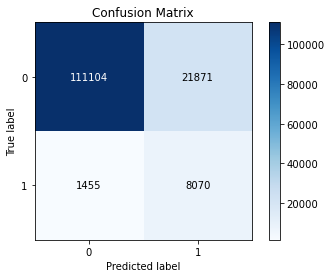

-------------------------------------------------------------
Evaluating test


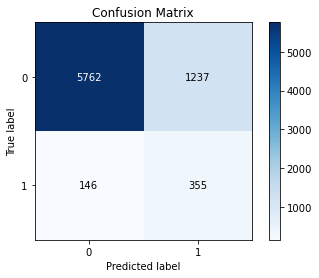

-------------------------------------------------------------
Evaluating train


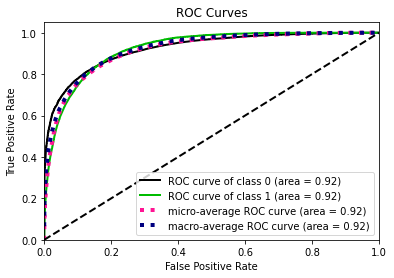

-------------------------------------------------------------
Evaluating test


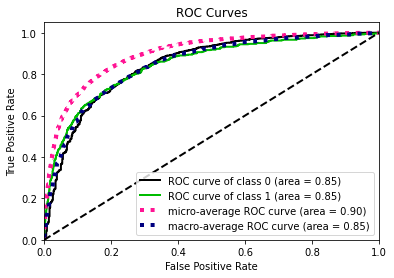

AUC Score Train:  0.9233920724940403
AUC Score Test:  0.8467994714956428


In [38]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)

# Resultado 2.3 - Random Forest 

In [51]:
model = otimizacao_rf(X_train, y_train)

0.9355578947368421
RandomForestClassifier(criterion='entropy', max_depth=80, max_features=2)
{'criterion': 'entropy', 'max_depth': 80, 'max_features': 2, 'n_estimators': 100}


In [55]:
model = otimizacao_rf_best(X_train, y_train)

0.9352771929824562


-------------------------------------------------------------
Evaluating train
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    132975
           1       0.78      0.29      0.42      9525

    accuracy                           0.95    142500
   macro avg       0.87      0.64      0.70    142500
weighted avg       0.94      0.95      0.94    142500

-------------------------------------------------------------
Evaluating test
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      6999
           1       0.58      0.19      0.28       501

    accuracy                           0.94      7500
   macro avg       0.76      0.59      0.63      7500
weighted avg       0.92      0.94      0.92      7500

-------------------------------------------------------------
Evaluating train


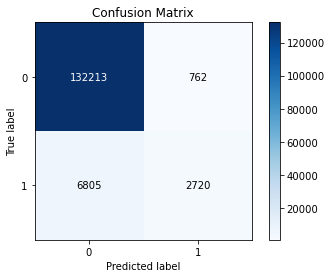

-------------------------------------------------------------
Evaluating test


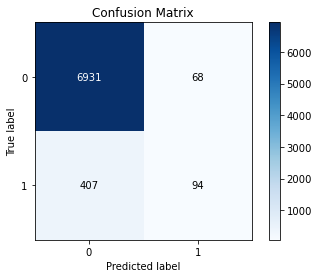

-------------------------------------------------------------
Evaluating train


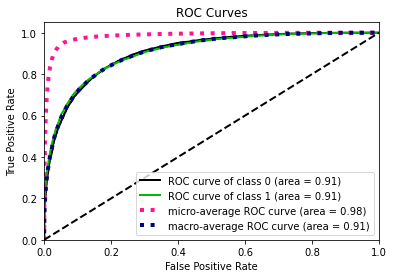

-------------------------------------------------------------
Evaluating test


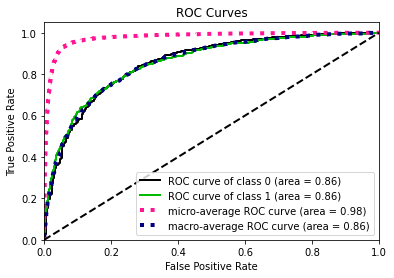

AUC Score Train:  0.9057658295251164
AUC Score Test:  0.855308385942788


In [56]:
# Preenchendo performance em treino e teste
res = {"train": {"actual": y_train,
               "pred": model.predict(X_train),
               "prob": model.predict_proba(X_train)},
     
       "test": {"actual": y_test,
               "pred": model.predict(X_test),
               "prob": model.predict_proba(X_test)}}

# Exibindo resultados
resultados(res)